In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import geopandas as gpd
import rioxarray as rio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'


#### Flow validation

In [2]:
src_dir = r"W:/VUB/_main_research/mHM/flow_data/waterinfo_csv/waterinfo_timeseries/"
station_locations = pd.read_csv(src_dir + "mhm_flow_stations_coordinates.csv")
sim_flow_mhm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States.nc")

#### Simulated data

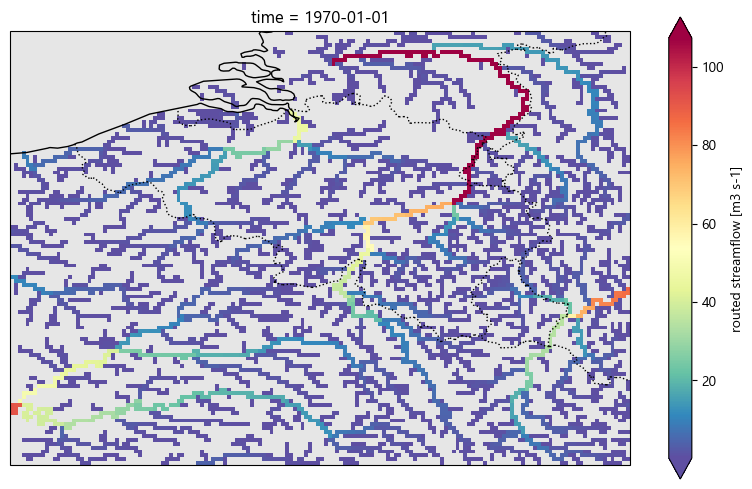

In [3]:
#sim_flow_mhm_calib['Qrouted'][0].plot(cmap='Spectral_r',robust=True)

# Assuming sim_flow_mhm_calib['Qrouted'][0] is your data array and it's correctly set up with coordinates
# Plot data where Qrouted is greater than 20
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
flow_data = sim_flow_mhm['Qrouted'][0].where(sim_flow_mhm['Qrouted'][0] > 0.15)
flow_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='0.9')
#ax.add_feature(cartopy.feature.LAKES, facecolor='0.9')
#ax.add_feature(cartopy.feature.RIVERS, edgecolor='blue')  # Changed to make rivers more visible
plt.show()

### Extract multistation data

In [4]:
#extracting the simulated flow
eval_station = {}

for station, row in station_locations.iterrows():
    station = row.stat_name
    mhm_flow = sim_flow_mhm['Qrouted'].sel(lat = row.lat, lon = row.lon, method = 'nearest') 
    sim_flow = mhm_flow.to_dataframe().drop(columns=['lat', 'lon'])

    observed = pd.read_csv(src_dir + f"{station}_Q.csv", parse_dates=True, index_col=0, dayfirst=True)
    observed[observed == -9999] = np.nan

    #fill blanks in observed data with nan
    observed = observed.resample('D').mean()

    obs_sim = pd.concat([observed, sim_flow], axis=1)
    obs_sim.columns = ['observed', 'simulated']
    obs_sim.dropna(inplace=True)
    obs_sim = obs_sim.resample('D').mean()

    eval_station[station] = obs_sim


### Goodness of Fit

In [5]:
def nse(observed, simulated):
    return np.round(1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)),2)
def pbias(observed, simulated):
    return np.round(np.sum((observed - simulated) / observed) * 100 / len(observed),2)
def kge(observed, simulated):
    return np.round(1 - np.sqrt((np.corrcoef(observed, simulated)[0, 1] - 1) ** 2 + (np.std(simulated, ddof=1) / np.std(observed, ddof=1) - 1) ** 2 + (np.mean(simulated) / np.mean(observed) - 1) ** 2),2)

In [6]:
kge_values = {}
nse_values = {}
pbias_values = {}

for station, data in eval_station.items():
    kge_values[station] = kge(data['observed'], data['simulated'])
    nse_values[station] = nse(data['observed'], data['simulated'])
    pbias_values[station] = pbias(data['observed'], data['simulated'])

In [ ]:
pbias_values = pd.Series(pbias_values)
pbias_values

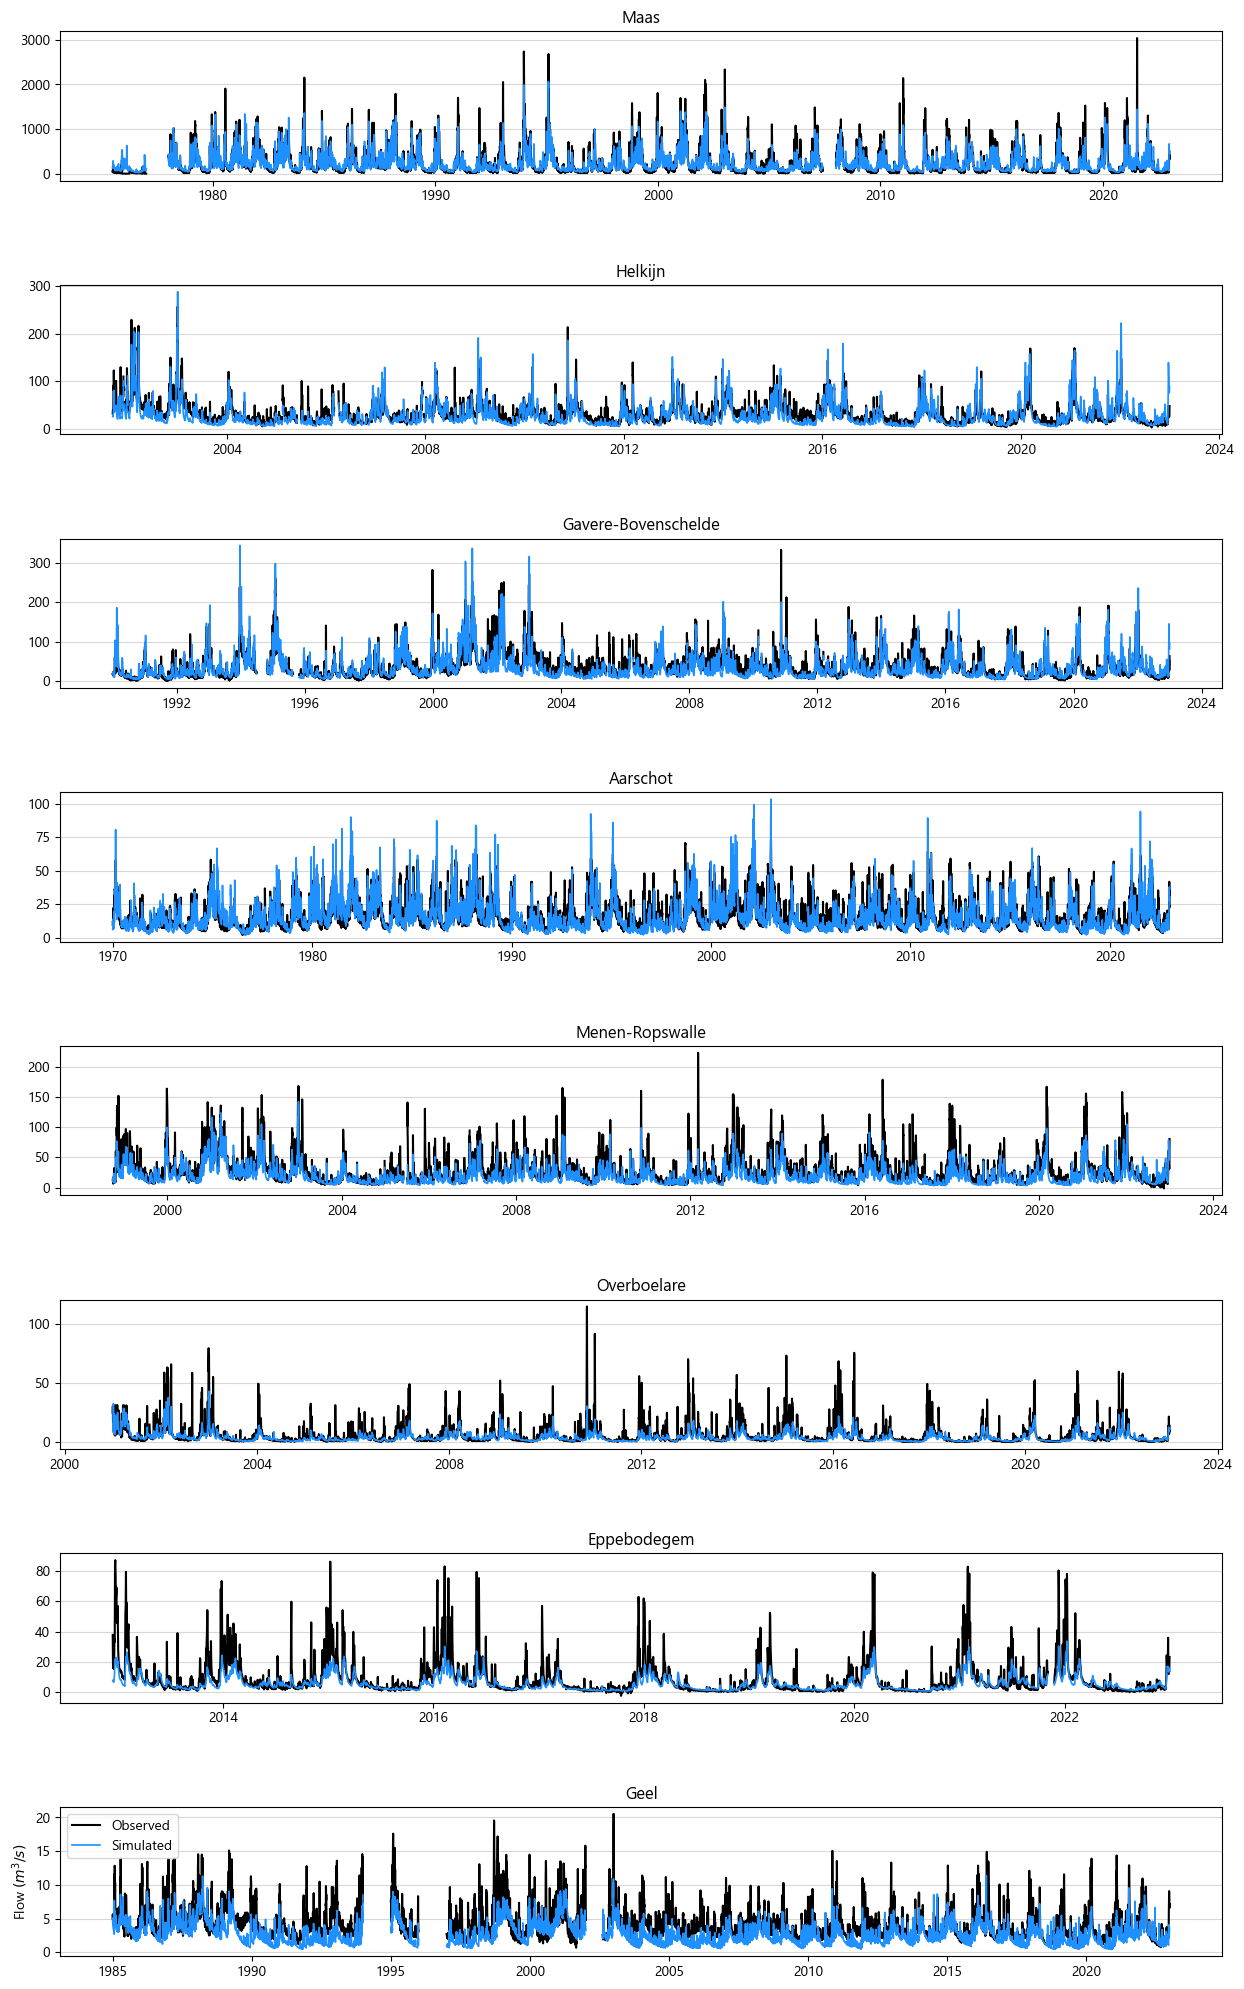

In [7]:
ncols = 1
nrows = len(eval_station)//ncols

fig, _ = plt.subplots(nrows, ncols, figsize=(15, 25))

#space between subplots
plt.subplots_adjust(hspace=0.7)

for stat in eval_station.keys():
    obs_sim = eval_station[stat]
    ax = plt.subplot(nrows, ncols, list(eval_station.keys()).index(stat)+1)
    ax.plot(obs_sim.index, obs_sim['observed'], label='Observed', color='black')
    ax.plot(obs_sim.index, obs_sim['simulated'], label='Simulated', color='dodgerblue', lw=1.2)
    ax.grid(alpha=0.5, axis='y')
    ax.set_title(stat)
plt.legend(loc='best')
plt.ylabel('Flow $(m^{3}/s)$');

### Spatial Datasets

In [17]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")
#resample to month ends
mhm_fluxes= mhm_fluxes.resample(time='ME').mean()
#Gleam root zone soil moisture
gleam_rzsm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\gleam_EUR_SMrz_EAS_2000_2023.nc")

#### Soil Moisture

In [ ]:
#Define ROI
roi = dict(lat=slice(51.5, 50.0), lon=slice(2.0, 3.5))

#extracting the simulated flow
mhm_sm_ts = mhm_fluxes['SM_L02'].sel(roi).mean(dim=['lat','lon']).to_dataframe()
gleam_sm_ts = gleam_rzsm['SMrz'].sel(roi).mean(dim=['lat','lon']).to_dataframe()

In [ ]:
gleam_sm_ts.index.max(), mhm_sm_ts.index.max()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 3.0))
ax2=ax.twinx()
#mhm soil moisture
ax.plot(mhm_sm_ts[gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='coral', lw=1.7, label='sm mHM')
ax2.plot(gleam_sm_ts[gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='dodgerblue', lw=1.5, label='sm GLEAM', alpha=0.9)
ax.set_ylabel('sm mHM', fontsize=12)
ax2.set_ylabel('sm GLEAM', fontsize=12)
plt.xticks(fontsize=15)
#collect legend handles and labels
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles + handles2, labels + labels2, fontsize=13)


In [ ]:
mhm_fluxes.data_vars

In [ ]:
r2 = np.corrcoef(gleam_sm_ts['SMrz'][mhm_sm_ts.index.min():mhm_sm_ts.index.max()],
                  mhm_sm_ts['SM_L03'][mhm_sm_ts.index.min():mhm_sm_ts.index.max()])[0,1]**2
r2

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
sm_data = mhm_fluxes['SWC_L03'][122]
sm_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')

In [ ]:
#resample to month ends
mhm_monthly_recharge = mhm_fluxes['recharge'].resample(time='ME').sum()
mhm_mon_average_recharge = mhm_monthly_recharge.groupby('time.month').mean(dim='time')
mhm_annual_recharge = mhm_monthly_recharge.groupby('time.year').sum()

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
data = mhm_mon_average_recharge[11]
data.plot(ax=ax, cmap='Spectral', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')

### Clip to Belgium

In [ ]:
#import rioxarray
#ref: https://gis.stackexchange.com/questions/289775/masking-netcdf-data-using-shapefile-xarray-geopandas
#ref: https://medium.com/@harismushtaq021/clip-netcdf-data-from-shapefile-using-rioxarray-and-geopandas-5e5e5337fdd
from shapely.geometry import mapping

be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")
be_shp = be_shp.to_crs(mhm_fluxes.rio.crs)

mhm_fluxes = mhm_fluxes.drop_dims("bnds", errors="ignore")
mhm_fluxes.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
mhm_fluxes.rio.write_crs("EPSG:4326", inplace=True)
clipped = mhm_fluxes.rio.clip(be_shp.geometry.apply(mapping), be_shp.crs, drop=True)

In [33]:
mhm_fluxes.lat[0].values-mhm_fluxes.lat[1].values

0.03125